# Simulation and Fitting of Femto-TA Data


Prerequisites: Basic knowledge of linear algebra and Python, good knowledge of [Numpy](https://numpy.org/) and [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html).


[Singluar Value Decomposition](#SVD) - what it is a how it can be helpfull with the analysis of kinetic data




Beer–Lambert law relates the concentration of the compound and its absorbance in cuvette of specific length with molar absorption coefficient that is specific for each molecule:

$$A(\lambda, t) = \varepsilon(\lambda)c(t)l = -\log T(\lambda, t) =  -\log{\frac{I(\lambda, t)}{I_0(\lambda, t)}}$$

where $A(\lambda, t)$ is absorbance at wavelength $\lambda$ and time $t$, $\varepsilon(\lambda)$ is molar absorption coefficient of compound at wavelenght $\lambda$, $c$ is the concentration of that compound, $l$ is the length of cuvette, $T$ is a transmitance (the part of transmitted light), $I$ is intensity of transmitted light and $I_0$ is intensity of incident light. Beer–Lambert law is additive, so for $k$ absorbing species in the same measured solution, resulting absorbance will be

$$A(\lambda, t) = l\sum_{i=0}^{k-1} c_i(t)\varepsilon_i(\lambda)$$

For transient absorption measurement, the change of absorbance is recorded: 

$$\Delta A(\lambda, t) = A(\lambda, t) - A_0(\lambda)$$

where $A_0(\lambda)$ denotes absorbance before excitation.

As we need to work with a discrete data, the recorded spectra at various times are represented as a matrix $\overset{n_t\ \times\ n_w}{\mathbf{D}}$, where $n_t$ is number of measured time points and $n_w$ is number of measured wavelength points.

$$\mathbf D=
\begin{bmatrix}
     A_{11} & A_{12} & A_{13} & \dots  & A_{1n_w} \\
     A_{21} & A_{22} & A_{23} & \dots  & A_{2n_w} \\
     \vdots & \vdots & \vdots & \ddots & \vdots \\
     A_{n_t1} & A_{n_t2} & A_{n_t3} & \dots  & A_{n_tn_w} 
\end{bmatrix}$$

To be able to simulate the matrix, we need to know spectra $\overset{n_w\ \times\ k}{\mathbf{S}}$ of the species and their concentration profiles $\overset{n_t\ \times\ k}{\mathbf{C}}$. These can be usefully represented as matrices. Matrix multiplication of these two matrices representes Beer-Lamber law in a discrete form.

$$\mathbf D  = l\mathbf C \mathrm{\mathbf{S}^T} $$


$$\mathbf D=
\begin{bmatrix}
     A_{11} & A_{12} & A_{13} & \dots  & A_{1n_w} \\
     A_{21} & A_{22} & A_{23} & \dots  & A_{2n_w} \\
     \vdots & \vdots & \vdots & \ddots & \vdots \\
     A_{n_t1} & A_{n_t2} & A_{n_t3} & \dots  & A_{n_tn_w} 
\end{bmatrix}=
l\begin{bmatrix}
     c_{11} & c_{12}  & \dots  & c_{1k} \\
     c_{21} & c_{22}  & \dots  & c_{2k} \\
     \vdots & \vdots  & \ddots & \vdots \\
     c_{n_t1} & c_{n_t2}  & \dots  & c_{n_tk} 
\end{bmatrix}
\begin{bmatrix}
     \varepsilon_{11} & \varepsilon_{12}  & \dots  & \varepsilon_{1n_w} \\
     \varepsilon_{21} & \varepsilon_{22}  & \dots  & \varepsilon_{2n_w} \\
     \vdots & \vdots &  \ddots & \vdots \\
     \varepsilon_{k1} & \varepsilon_{k2}  & \dots  & \varepsilon_{kn_w} 
\end{bmatrix}=l\mathbf C \mathrm{\mathbf{S}^T}$$


This formulation is basically the sum of outer products of concentration profiles and spectra:

$$\mathbf D = l\sum_{i=0}^{k - 1} \mathbf c_i {\mathbf\varepsilon}_i^{\mathrm T}$$

where $\mathbf c_i$ and $\mathbf\varepsilon_i$  are columns of $\mathbf C$ and $\mathbf S$ matrices. Outer product is a product of two vector and the result is a matrix. On the other hand, inner product is basically dot product and result is a number. Vectors has to have in this case the same dimension.

For simulation purposes we will simulate some gaussian spectra composed of ground state bleach (GSB), excited state absorption (ESA) and stimulated emission (SE) bands.

[1] Marcel Meader; Practical Data Analysis in Chemistry. 2007. Elsevier. ISBN: 978-0-444-53054-7 <br>
[2] van Stokkum, I. H. M., Larsen, D. S., & van Grondelle, R. (2004). Global and target analysis of time-resolved spectra. Biochimica et Biophysica Acta (BBA) - Bioenergetics, 1657(2–3), 82–104. https://doi.org/10.1016/j.bbabio.2004.04.011 <br>

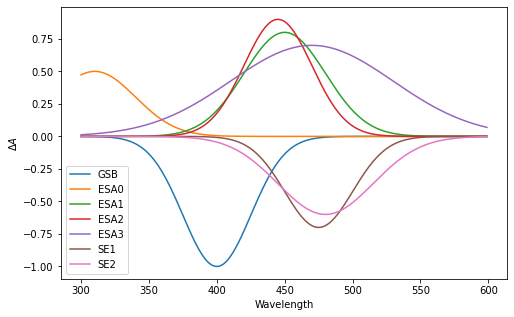

In [129]:
import numpy as np  # import numpy package
import matplotlib.pyplot as plt  # we plot graphs with this library
from matplotlib.ticker import SymmetricalLogLocator, ScalarFormatter, AutoMinorLocator, MultipleLocator, Locator
import warnings
warnings.filterwarnings("ignore")  # get rid of stupid warnings mainly from matplotlib
%matplotlib inline

wavelengths = np.arange(300, 600)  # linear space of wavelengths from 300 to 599 in arbitrary units

# define gaussian function (without a scaling factor) for creating sample spectra
def gauss(x, mu, sigma):
    return np.exp(-(x - mu) * (x - mu) / (2 * sigma * sigma))

GSB = -gauss(wavelengths, 400, 25)  # ground state bleach
ESA0 = 0.5 * gauss(wavelengths, 310, 30)  # excited state absorption band 0
ESA1 = 0.8 * gauss(wavelengths, 450, 30)  # excited state absorption band 1
ESA2 = 0.9 * gauss(wavelengths, 445, 25)  # excited state absorption band 2
ESA3 = 0.7 * gauss(wavelengths, 470, 60)  # excited state absorption band 3
SE1 = -0.7 * gauss(wavelengths, 475, 25)  # stimulated emission 1
SE2 = -0.6 * gauss(wavelengths, 480, 35)  # stimulated emission 2

# plot individual bands
plt.rcParams['figure.figsize'] = [8, 5]

plt.plot(wavelengths, GSB, label='GSB')
plt.plot(wavelengths, ESA0, label='ESA0')
plt.plot(wavelengths, ESA1, label='ESA1')
plt.plot(wavelengths, ESA2, label='ESA2')
plt.plot(wavelengths, ESA3, label='ESA3')
plt.plot(wavelengths, SE1, label='SE1')
plt.plot(wavelengths, SE2, label='SE2')

plt.xlabel('Wavelength')
plt.ylabel('$\Delta A$')
plt.legend()
plt.show()

## Create and plot the species

First species could consist of GSB, ESA1 and SE1 band, which could be unrelaxed singlet state. The other is relaxed singlet state so the spectrum is very similar. The last species is different state, e.g. triplet state. Note that individual bands cannot be resolved in TS measurements. Only their sum is observed.

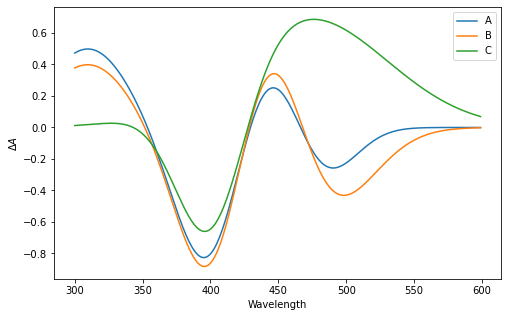

In [130]:
n_w = wavelengths.shape[0]  # dimensions of wavelenths vector
k = 3  # number of species

# define a spectra matrix with dimensions n_w x k of 64 bit float
S = np.empty((n_w, k), dtype=np.float64)  

S[:, 0] = GSB + ESA1 + SE1 + ESA0
S[:, 1] = GSB + ESA2 + SE2 + 0.8 * ESA0
S[:, 2] = GSB + ESA3

species = list('ABC')

# plot created spectra
plt.rcParams['figure.figsize'] = [8, 5]
for i in range(k):
    plt.plot(wavelengths, S[:, i], label=species[i])
plt.xlabel('Wavelength')
plt.ylabel('$\Delta A$')
plt.legend()
plt.show()

## Create a kinetic model

Typically, species undergoes first order kinetics. The higher orders are observed in longer times (nanosecond timescale) where bimolecular processes can occur. Many times, the observed kinetics is non-exponential due to some vibrational and solvation relaxation processes which causes the spectra or stimulated emission to shift, therefore the first order kinetic model is only approximation and such data can be fitted with the usage of more species. We will use evolution model. Which means that the kinetics starts with species A, then goes to B and then from B to C and then decays to zero. The time evolution can be described by the following matrix differential equation:

$$\frac{\mathrm{d}\bf{c}}{\mathrm{d}t} = \mathbf{Kc} +  i(t)\mathbf{j} $$
where $$\mathbf c=
\begin{pmatrix}
     c_A(t) \\
     c_B(t)  \\
     c_C(t) 
\end{pmatrix}
$$ is concetration vector in our case and consits only from three species and 
$$\mathbf j=
\begin{pmatrix}
     1 \\
     0  \\
     0  \\
\end{pmatrix}
$$
 is initial population vector. The $$\mathbf K=
\begin{bmatrix}
     -k_{A} & 0  & 0  \\
     k_{A} & -k_{B} & 0 \\
     0  & k_{B} & -k_{C}\\
\end{bmatrix}
$$ is a transfer matrix that describes evolution kinetic model. Species are connected with individal rate constants. The $i(t)$ represents the instrument response function and determines the time resolution of the system. Usually it is approximated as gaussian $$i(t) = \frac{1}{\sigma\sqrt{2\pi}}\exp\left(-\frac{t^2}{2\sigma^2}\right) $$ where $\tilde\Delta = \frac{\Delta}{2\sqrt{\ln2}}$ and $\Delta$ is FWHM (full width at half maximum) of the gaussian. Experimentally it is given by convolution of pump and probe pulses. 

General solution of the matrix differential equation is $\mathbf c(t) = e^{\mathbf Kt} * i(t)\mathbf j$ where * denotes [convolution](https://en.wikipedia.org/wiki/Convolution). This is however not very usefull for efficient simulation, because the matrix exponential is very expensive operation. It can be simplified if we diagonalize the matrix $\mathbf K$. Then the matrix exponential is trivial. $\mathbf K$ can be diagonalized by eigenvalue eigenvector decomposition $\mathbf K = \mathbf{U\Lambda U^{-1}}$. Then the general solution is 

$$ \mathbf{A_{II}^T} = \mathbf U \mathrm{diag}(\mathbf{U^{-1}j}) $$
and $$\mathbf c(t) = \big(\exp\left(-\mathrm{diag}(\mathbf \Lambda)t\right) * i(t)\big)  \mathbf{A_{II}}$$

Exponentials convoluted with a gaussian will be called folded exponential and are defined as 
$$c_i(t) = e^{-kt}\theta(t)*i(t) = \frac12 e^{k\left(\frac{k\sigma^2}{2} - t\right)}\mathrm{erfc}\left(\frac{k\sigma}{\sqrt2} - \frac{t}{\sqrt2\sigma}\right) = \frac12 e^{k\left(\frac{k \tilde\Delta^2}{4} - t\right)}\mathrm{erfc}\left(\frac{k \tilde\Delta}{2} - \frac{t}{ \tilde\Delta}\right)$$

where $\theta(t)$ is Heaviside step function and $\mathrm{erfc}$ is complementary error function.

This basically means that an arbitrary kinetics model is a linear combination of basis of folded exponential functions that uses the negative eigenvalues of the transfer matrix as an argument.

For detailed derivation and explanation of kinetic model, see van Stokkum, I. H. M., Larsen, D. S., & van Grondelle, R. (**2004**). Global and target analysis of time-resolved spectra. *Biochimica et Biophysica Acta (BBA) - Bioenergetics*, *1657(2–3)*, 82–104. https://doi.org/10.1016/j.bbabio.2004.04.011
or Joseph S. Beckwith, Christopher A. Rumble & Eric Vauthey (**2020**) *Data analysis in transient electronic spectroscopy – an experimentalist's view*, International Reviews in Physical Chemistry, 39:2, 135-216, DOI: https://10.1080/0144235X.2020.1757942


In [131]:
# linear + logspace of times -1 to 1000 in arbitrary units
times = np.concatenate((np.linspace(-1, 1, 200, endpoint=False), np.logspace(0, 3, 200)))  

n_t = times.shape[0]  # dimensions of times vector
# C = np.empty((n_t, k), dtype=np.float64)  # define concentration matrix with dimensions n_t x k with float64 dtype

# show the times
print(f'Dimensions of times vector: {times.shape}')
times[::4]  # show every forth time point

Dimensions of times vector: (400,)


array([-1.00000000e+00, -9.60000000e-01, -9.20000000e-01, -8.80000000e-01,
       -8.40000000e-01, -8.00000000e-01, -7.60000000e-01, -7.20000000e-01,
       -6.80000000e-01, -6.40000000e-01, -6.00000000e-01, -5.60000000e-01,
       -5.20000000e-01, -4.80000000e-01, -4.40000000e-01, -4.00000000e-01,
       -3.60000000e-01, -3.20000000e-01, -2.80000000e-01, -2.40000000e-01,
       -2.00000000e-01, -1.60000000e-01, -1.20000000e-01, -8.00000000e-02,
       -4.00000000e-02,  0.00000000e+00,  4.00000000e-02,  8.00000000e-02,
        1.20000000e-01,  1.60000000e-01,  2.00000000e-01,  2.40000000e-01,
        2.80000000e-01,  3.20000000e-01,  3.60000000e-01,  4.00000000e-01,
        4.40000000e-01,  4.80000000e-01,  5.20000000e-01,  5.60000000e-01,
        6.00000000e-01,  6.40000000e-01,  6.80000000e-01,  7.20000000e-01,
        7.60000000e-01,  8.00000000e-01,  8.40000000e-01,  8.80000000e-01,
        9.20000000e-01,  9.60000000e-01,  1.00000000e+00,  1.14895100e+00,
        1.32008840e+00,  

### Define the functions for simulation of kinetics

In [132]:
from numpy.linalg import eig, inv
from numba import vectorize  # use numba here to speed-up calculations, https://numba.pydata.org/numba-doc/latest/user/vectorize.html
from math import erfc

# define a functions for simulation of concentration matrix

@vectorize(nopython=True)  # creates and compiles a vectorized function, will work on numpy arrays
def fold_exp(t, k, fwhm=0):
    """t - times, k - rate constant vector, fwhm - full width at half maximum"""
    
    w = fwhm / (2 * np.sqrt(np.log(2)))  # width, Delta with tilde

    if w > 0:
        return 0.5 * np.exp(k * (k * w * w / 4.0 - t)) * erfc(w * k / 2.0 - t / w)  # calculate the folded exponential if width > 0
    else:
        return np.exp(-t * k) if t >= 0 else 0  # normal exponential if fwhm = 0, but for t < 0, values must be zero (the heaviside function)

def simulate_C(t, K, j, fwhm=0):
    """t - times, K - transfer matrix, j - initial population vector, fwhm - full width at half maximum"""
    
    Lambda, U = eig(K)  # get eigenvalues and eigenvectors of K
    U_inv = inv(U)  # calculate the inverse of U

    # calculate A_II^T matrix
    A_II_T = U * U_inv.dot(j)  # U @ diag(U^-1 @ j)
    
    # calculate basis of folded exponentials
    C = fold_exp(t[:, None], -Lambda[None, :], fwhm)
    
    # make linar combination of folded exponentials
    return C.dot(A_II_T.T)  # C @ A_II


### Define rate constants and simulate the model

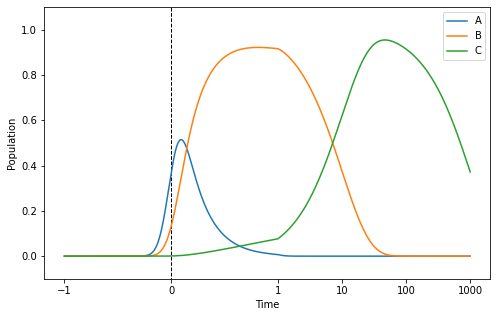

In [133]:
taus = np.asarray([0.2, 10, 1e3])  # lifetimes
ks = 1 / taus  # rate constants

K = np.zeros((k, k))  # transfer matrix
# fill the rate constants as sequential model
for i in range(k):
    K[i, i] = -ks[i]
    if i < k - 1:
        K[i + 1, i] = ks[i]

j = np.zeros(k)  # define the j vector
j[0] = 1

fwhm = 0.2  # use FWHM as 0.2
C = simulate_C(times, K, j, fwhm)

# plot computed concentrations with symlog scale
plt.rcParams['figure.figsize'] = [8, 5]
for i in range(k):
    plt.plot(times, C[:, i], label=species[i])
plt.xlabel('Time')
plt.ylabel('Population')
plt.xscale('symlog', linthresh=1, linscale=1.5)
plt.ylim(-0.1, 1.1)
plt.vlines(0, -5, 5, color='k', ls='--', lw=1)
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.legend()
plt.show()

## Generate the TA data

Now, we have spectra and concentration profiles, so it is very easy to generate the data matrix.


In [134]:
D = C @ S.T  # matrix multiply
print(f'Dimensions of matrix D: {D.shape}')
D

Dimensions of matrix D: (400, 300)


array([[ 1.24576828e-32,  1.25884482e-32,  1.27062348e-32, ...,
        -1.99471366e-36, -1.80657478e-36, -1.63507246e-36],
       [ 4.99760208e-32,  5.05006071e-32,  5.09731269e-32, ...,
        -8.07680354e-36, -7.31501544e-36, -6.62056604e-36],
       [ 1.97745861e-31,  1.99821550e-31,  2.01691222e-31, ...,
        -3.22594054e-35, -2.92167768e-35, -2.64430078e-35],
       ...,
       [ 4.89210148e-03,  5.11136516e-03,  5.33709740e-03, ...,
         2.96144199e-02,  2.85839318e-02,  2.75816388e-02],
       [ 4.73352013e-03,  4.94567621e-03,  5.16409116e-03, ...,
         2.86544451e-02,  2.76573610e-02,  2.66875582e-02],
       [ 4.57475143e-03,  4.77979150e-03,  4.99088052e-03, ...,
         2.76933360e-02,  2.67296955e-02,  2.57924211e-02]])

### Plot the matrix as heatmap


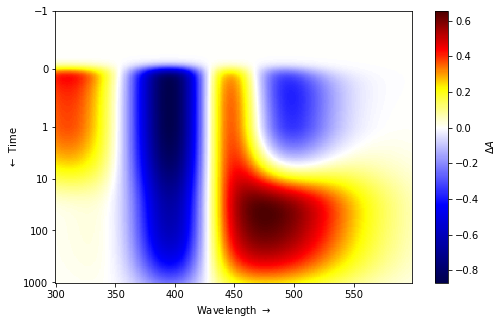

In [135]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

def register_div_cmap(zmin, zmax):  # colors for femto TA heat maps: dark blue, blue, white, yellow, red, dark red
    """color map suited for the data so that zero will be always in white color.
    Colormap needs to adjusted for the data."""

    diff = zmax - zmin
    w = np.abs(zmin / diff)  # white color point set to zero z value

    _cdict = {'red': ((0.0, 0.0, 0.0),
                      (w / 2, 0.0, 0.0),
                      (w, 1.0, 1.0),
                      (w + (1 - w) / 3, 1.0, 1.0),
                      (w + (1 - w) * 2 / 3, 1.0, 1.0),
                      (1.0, 0.3, 0.3)),

              'green': ((0.0, 0, 0),
                        (w / 2, 0.0, 0.0),
                        (w, 1.0, 1.0),
                        (w + (1 - w) / 3, 1.0, 1.0),
                        (w + (1 - w) * 2 / 3, 0.0, 0.0),
                        (1.0, 0.0, 0.0)),

              'blue': ((0.0, 0.3, 0.3),
                       (w / 2, 1.0, 1.0),
                       (w, 1.0, 1.0),
                       (w + (1 - w) / 3, 0.0, 0.0),
                       (w + (1 - w) * 2 / 3, 0.0, 0.0),
                       (1.0, 0.0, 0.0))
              }

    custom_cmap = LinearSegmentedColormap('diverging', _cdict)
    cm.register_cmap('diverging', custom_cmap)
    
    
def plot_matrix(times, wavelengths, D, mu=None):
    register_div_cmap(D.min(), D.max())
    
    x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image
    
    # for plotting of the chirp, see later text
    if mu is not None:
        plt.plot(wavelengths, mu, ls='--', color='k')
    
    plt.pcolormesh(x, y, D, cmap='diverging', shading='auto')
    plt.colorbar(label='$\Delta A$')
    plt.xlabel('Wavelength $\\rightarrow$')
    plt.ylabel('$\\leftarrow$ Time ')
    plt.gca().invert_yaxis()
    plt.yscale('symlog', linthresh=1, linscale=1)
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.show()
    
plot_matrix(times, wavelengths, D)

## Addition of chirp (group velocity dispersion)

Because speed of light in the measured medium is dependent on the wavelength, blue fotons will hit the detector earlier than the red photons. This causes the chirp and the beginning of the signal is shifted. The chirp can be described as a polynomial (as is in software GloTarAn or Optimus) and this function defines the real time zero for each wavelength:

$$\mu(\lambda) = \sum_{i=0}^{m}\mu_i\left(\frac{\lambda - \lambda_c}{100}\right)^i$$

where $m$ is the order of the polynomial, $\mu_i$ are the polynomial coefficients and $\lambda_c$ is the "central wave" which is the arbitrary parameter to be chosen. Then $\mu_0 = \mu(\lambda_c)$ first parameter defines the time zero at central wave. The $100^i$ in the denominator is there to keep all the polynomial coefficients in a similar order. It would cause severe problems in fitting in case this scaling coefficient would not be there. Addition of chirp complicates stuff. Now we cannot use concentration matrix to represent concentration profiles, but instead, the concentration matrix will be defined for each wavelength, because time zero is always different. So we have to define concentration tensor. The dimensions were ($n_t, k$) and will now be ($n_w, n_t, k$). Also the simple matrix multiply to get the data matrix is not longer valid. We have to use **batched matrix vector** multiplication. In numpy, there is usefull `np.matmul` function for this. So, the each column of $\mathbf D$ is $\mathbf d_i =  \mathbf C[i, :, :] \mathbf s_i$.



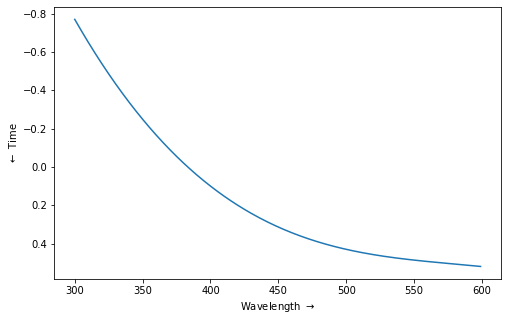

In [136]:
# central wave
lambda_c = 400
# polynomial coefficients
parmu = np.asarray([0.1, 0.55, -0.27, 0.05])

mu = np.ones(wavelengths.shape[0], dtype=np.float64) * parmu[0]

for i in range(1, len(parmu)):
    mu += parmu[i] * ((wavelengths - lambda_c) / 100) ** i

# plot chirp
plt.plot(wavelengths, mu)
plt.gca().invert_yaxis()
plt.xlabel('Wavelength $\\rightarrow$')
plt.ylabel('$\\leftarrow$ Time ')
plt.show()   

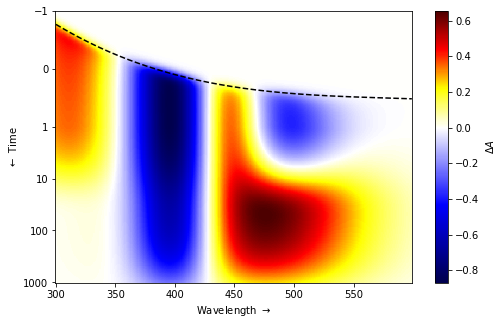

In [137]:
# we need to modify the function for simulation of concentration profiles
def simulate_C(t, K, j, fwhm=0, mu=None):
    """t - times, K - transfer matrix, j - initial population vector, fwhm - full width at half maximum"""
    
    Lambda, U = eig(K)  # get eigenvalues and eigenvectors of K
    U_inv = inv(U)  # calculate the inverse of U

    # calculate A_II^T matrix
    A_II_T = U * U_inv.dot(j)  # U @ diag(U^-1 @ j)
    
    # for wavelength-dependent IRF, see further text
    _tau = fwhm[:, None, None] if isinstance(fwhm, np.ndarray) else fwhm
    
    if mu is not None:
        # generate concentration tensor
        C = fold_exp(t[None, :, None] - mu[:, None, None], -Lambda[None, None, :], _tau)
    else:
        # keep the original line if mu is not provided
        C = fold_exp(t[:, None], -Lambda[None, :], _tau)
    
    # make linar combination of folded exponentials
    return C.dot(A_II_T.T)  # C @ A_II, works on tensors as well

# get profiles
C = simulate_C(times, K, j, fwhm, mu)

# multiplication of C (n_w, n_t, k) with S (n_w, k, 1), therefore S matrix needs another dimension
# result is D (n_w, n_t, 1) and the last dimension is removed, then matrix is transposed
D = np.matmul(C, S[..., None]).squeeze().T  # batched matrix vector multiply

plot_matrix(times, wavelengths, D, mu) # fwhm = 0.2

## Wavelength-dependency of the IRF

The time resolution is given by the convolution of pump and probe pulses. It is common that the width of supercontinuum probe is dependent on the wavelenght, so the overall time resolution will also be dependent on wavelength. Similar to chirp, wavelength-dependency of IRF can be described by a polynomial which determines the FWHM at wavelength $\lambda$:

$$\tau(\lambda) = \sum_{i=0}^{m}\tau_i\left(\frac{\lambda - \lambda_c}{100}\right)^i$$

where $m$ is the order of the polynomial, $\tau_i$ are the polynomial coefficients and $\lambda_c$ is the central wave.  Then $\tau_0 = \tau(\lambda_c)$ first parameter defines the FWHM at central wave. 


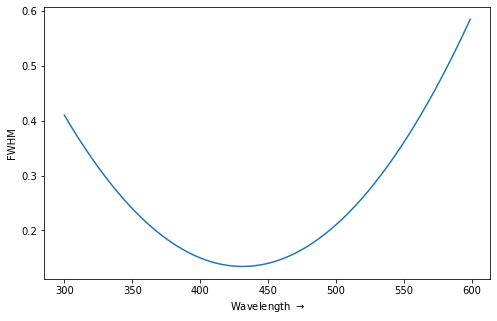

In [214]:
# polynomial coefficients, greatly exagarated
partau = np.asarray([0.15, -0.1, 0.16])

tau = np.ones(wavelengths.shape[0], dtype=np.float64) * partau[0]

for i in range(1, len(partau)):
    tau += partau[i] * ((wavelengths - lambda_c) / 100) ** i

# plot FWHM dependency
plt.plot(wavelengths, tau)
# plt.gca().invert_yaxis()
plt.xlabel('Wavelength $\\rightarrow$')
plt.ylabel('FWHM')
plt.show()   

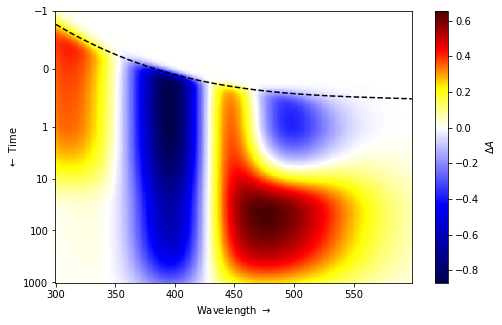

In [215]:
# get profiles, instead of fwhm, use simulated tau
C = simulate_C(times, K, j, tau, mu)

# batched matrix vector multiply
D = np.matmul(C, S[..., None]).squeeze().T  

plot_matrix(times, wavelengths, D, mu)

## Addition of Coherent Artifacts


The time resolution is given by the convolution of pump and probe pulses. It is common that the width of supercontinuum probe is dependent on the wavelenght, so the overall time resolution will also be dependent on wavelength. Similar to chirp, wavelength-dependency of IRF can be described by a polynomial which determines the FWHM at wavelength $\lambda$:


Gaussian derivatives


\begin{align}
i(t, \mu, \sigma) &= \frac{1}{\sigma \sqrt{2\pi}}\exp\left(-\frac{(t - \mu)^2}{2\sigma^2}\right) \\
i^\prime(t, \mu, \sigma) &= \frac{t - \mu}{\sigma^2} i(t, \mu, \sigma) \\
i^{\prime\prime}(t, \mu, \sigma) &= \left(\frac{(t - \mu) ^ 2}{\sigma^4} - \frac{1}{\sigma ^2}\right) i(t, \mu, \sigma) \\
i^{\prime\prime\prime}(t, \mu, \sigma) &= \left(\frac{(t - \mu) ^ 3}{\sigma^6} - \frac{3(t - \mu)}{\sigma ^4}\right) i(t, \mu, \sigma) 
\end{align}



where $m$ is the order of the polynomial, $\tau_i$ are the polynomial coefficients and $\lambda_c$ is the central wave.  Then $\tau_0 = \tau(\lambda_c)$ first parameter defines the FWHM at central wave. 


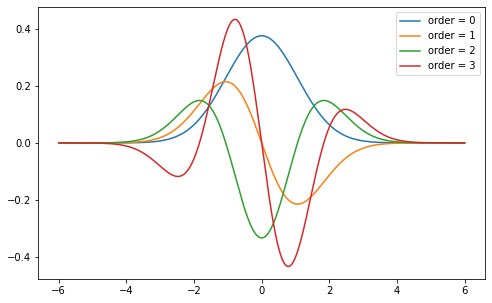

In [216]:
def gaussian_derivatives(t, fwhm: [int, float, np.ndarray] = 0.2, mu: [int, float, np.ndarray] = 0, normalized=False):
    s = fwhm / (2 * np.sqrt(2 * np.log(2)))  # calculate sigma from fwhm
    
    if isinstance(mu, np.ndarray):
        mu = mu[:, None]
        t = t[None, :]
    if isinstance(s, np.ndarray):
        s = s[:, None]
        t = t[None, :] if t.ndim == 1 else t
        
    tt = t - mu    # t - mu
    tt2 = tt * tt  # (t - mu) ^ 2
    s2 = s * s     # square of sigma
    
    # gaussian
    gauss = np.exp(-0.5 * tt2 / s2) / (s * np.sqrt(2 * np.pi))
    
    g_derivs = np.tile(gauss, [4] + tt.ndim * [1])
    
    g_derivs[1] *= -tt / s2                                            # first derivative
    g_derivs[2] *=  ( tt2 / (s2 * s2) - 1 / s2 )                       # second derivative
    g_derivs[3] *=  ( tt2 * tt / (s2 * s2 * s2) - 3 * tt / (s2 * s2))  # third derivative
    
    if normalized:
        g_derivs /= g_derivs.max(axis=-1, keepdims=True)
    
    return g_derivs
    
_t = np.linspace(-6, 6, 1000)
g_derivs = gaussian_derivatives(_t, 2.5, normalized=False)
for i in range(g_derivs.shape[0]):
    plt.plot(_t, g_derivs[i], label=f'order = {i}')

plt.legend()
plt.show() 

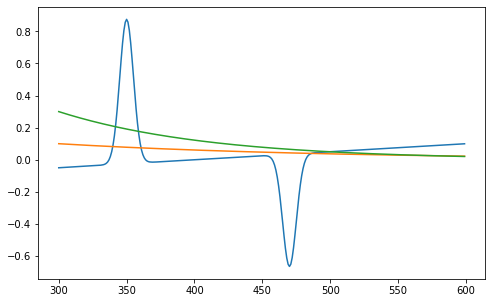

In [237]:
# create a spectra matrix
S_COH = np.zeros((n_w, 3), dtype=np.float64)

# coherent artifacts spectra
S_COH[:, 0] = -0.7 * gauss(wavelengths, 470, 5) + 0.9 * gauss(wavelengths, 350, 5) + (wavelengths - 300) * 0.0005 - 0.05
S_COH[:, 1] = 0.1*np.exp(-(wavelengths - 300) * 0.005)
S_COH[:, 2] = 0.3*np.exp(-(wavelengths - 300) * 0.009)

for i in range(S_COH.shape[1]):
    plt.plot(wavelengths, S_COH[:, i])
    
plt.show()    

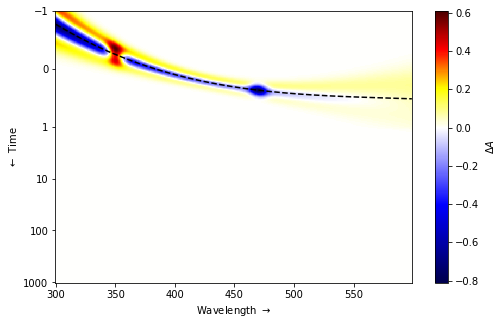

In [238]:
# simulate artifacts, include the chirp and plot the matrix

C_COH = gaussian_derivatives(times, tau, mu, normalized=True)[:-1, ...]  # remove the last derivative
C_COH = C_COH.transpose(1, 2, 0)  # transpose dimensions for batch matrix vector multiplication

D_COH = np.matmul(C_COH, S_COH[..., None]).squeeze().T  

plot_matrix(times, wavelengths, D_COH, mu)

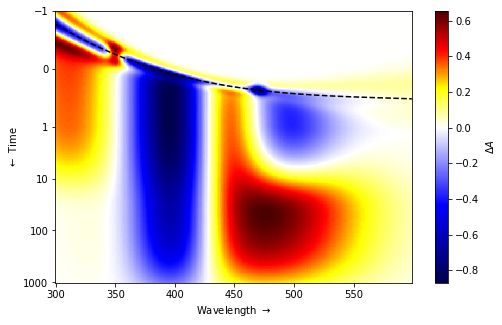

In [239]:
# addition of simulated data and coherent artifacts together
D_full = D + D_COH

plot_matrix(times, wavelengths, D_full, mu)

## Addition of Noise



<a id='SVD'></a>
## Singular value decomposition

With our sample matrix $\mathbf A$, we can now try to guess matrices $\mathbf C$ and $\mathbf E$. Singular value decomposition will help us identify, how many components our system is composed of and from that knowledge. Next, we will decompose the large matrix $\mathbf A$ into only 3 small matrices. This will then greatly speed up the fitting procedure.

By applying SVD (Singular value decomposition) to $\boldsymbol{\mathrm{A}}$, we can rewrite 

Data matrix $\boldsymbol{\mathrm{A}}$ with dimensions $t\times w$, where $t$ is number of measured times and $w$ is number of measured wavelenghts, can be respresented by as a product of three matrices. 

$$\mathbf A = \mathbf{U\Sigma V^T}$$

left side vectors are orthonormal eigenvectors
right side vectors are orthonormal eigenvectors

Orthogonality - the two vectors are orthogonal, if and only if their dot product is 0.

$$\langle f_i, f_j\rangle = \delta_{i,j}$$

$$\mathbf{V^{-1}V = V^TV = I = U^TU = U^{-1}U}$$

Kronecker delta

Orthonormality - the vector are orthonormal, if and only if they are orthogonal and normalized, so that the size is 1.

$$\parallel f_i\parallel = 1$$



Nice explanation of SVD is [here](https://www.quora.com/What-is-an-intuitive-explanation-of-singular-value-decomposition-SVD).


In [7]:
from scipy.linalg import svd  # import svd function from scipy library

# we don't need full matrices, furthermore, computation is a lot faster and memory benign
U, S, V_T = svd(A, full_matrices=False)

print(U.shape, S.shape, V_T.shape)  # !Sigma is returned as a simple 1D array, not a diagonal matrix!

(500, 300) (300,) (300, 300)


In [8]:
S[:5]  # show first 5 singular values

array([1.06955193e+02, 9.71359402e+00, 3.54880324e-14, 1.59818477e-14,
       1.23952654e-14])

## Visualize found column and row vectors and reconstruct the matrix for 3 non-zero singular values.

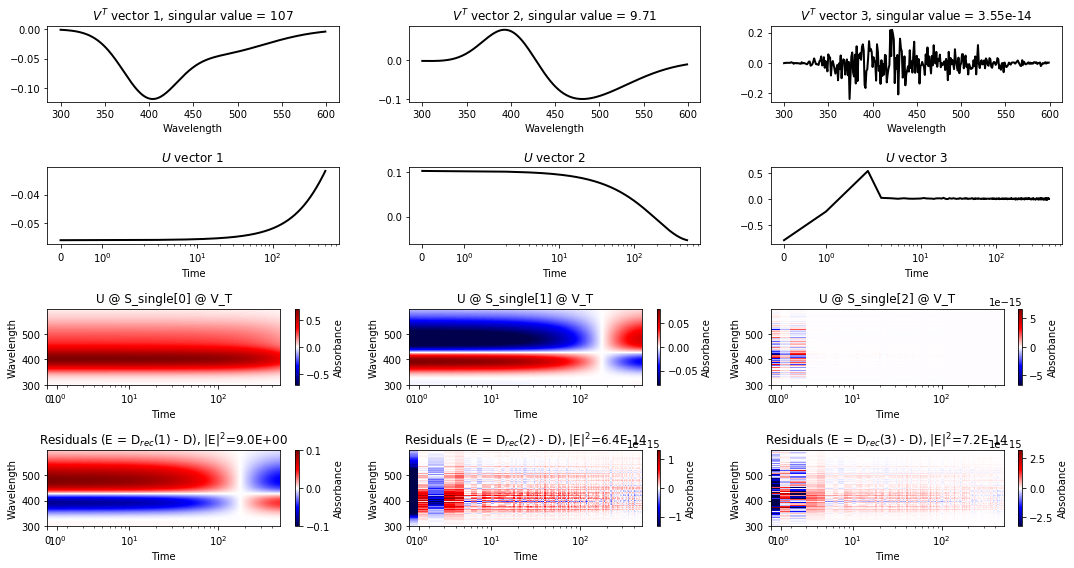

In [9]:
def plot_first_n_vectors(n, U, S, V_T, times, wavelengths):
    S_single = []  # define a list of diagonal matrices with only one singular value
    for i in range(n):
        S_i = np.zeros((S.shape[0], S.shape[0]))  # recreate diagonal matrices
        S_i[i, i] = S[i]
        S_single.append(S_i)
    
    plt.rcParams['figure.figsize'] = [15, 8]
    x, y = np.meshgrid(times, wavelengths)  # needed for pcolormesh to correctly scale the image
    for i in range(n):
        plt.subplot(4, n, i+1)
        plt.plot(wavelengths, V_T[i], color='black', lw=2)
        plt.title("$V^T$ vector {}, singular value = {:.3g}".format(i+1, S[i]))
        plt.xlabel('Wavelength')
    for i in range(n):
        plt.subplot(4, n, i+n+1)
        plt.xscale('symlog', subsx=[1,2,3,4,5,6,7,8,9])

        plt.plot(times, U[:, i], color='black', lw=2)
        plt.title(f"$U$ vector {i+1}")
        plt.xlabel('Time') 
    for i in range(n):
        plt.subplot(4, n, i+2*n+1)
        plt.xscale('symlog', subsx=[1,2,3,4,5,6,7,8,9], linscalex=0.2)

        A_rec = U @ S_single[i] @ V_T  # reconstruct the A matrix for this i-th component
        # setup z range so that white color corresponds to 0
        plt.pcolormesh(x, y, A_rec.T, cmap='seismic', vmin=-np.abs(np.max(A_rec)), vmax=np.abs(np.max(A_rec)))
        plt.colorbar(label='Absorbance')
        plt.title(f"U @ S_single[{i}] @ V_T")
        plt.ylabel('Wavelength')
        plt.xlabel('Time')
        
        plt.subplot(4, n, i + 3 * n + 1)
        plt.xscale('symlog', subsx=[1,2,3,4,5,6,7,8,9], linscalex=0.2)

        Sd = np.diag(S) # create sigma diagonal matrix from S
        Ur = U[:, :i+1]
        Sr = Sd[:i+1, :i+1]
        V_Tr = V_T[:i+1, :]
        Ar = Ur @ Sr @ V_Tr
        A_diff = Ar - A
        
#         E2 = (A_diff * A_diff).sum()
        E2 = 100 * np.sqrt((A_diff * A_diff).sum() / (A*A).sum()) 

        
        plt.pcolormesh(x, y, A_diff.T, cmap='seismic', vmin=-np.abs(np.max(A_diff)), vmax=np.abs(np.max(A_diff)))
        plt.colorbar(label='Absorbance')
        title = "Residuals (E = D$_{{rec}}$({}) - D)".format(i+1)
        plt.title(title + f", |E|$^2$={E2:.1E}")
        plt.ylabel('Wavelength')
        plt.xlabel('Time')
    plt.tight_layout()
    plt.show()
    

plot_first_n_vectors(3, U, S, V_T, times, wavelengths)

## Logaritmic plot of singular values

Another great tool, how to estimate number of significant components in the system is the plot of first $n$ singular values, keeping y axis in log scale. We can see from the below graph, that only first 3 components are significant, which is correct, because we constructed the matrix from 3 individual spectra. The other values are not zero, but are extremally small ($\sim 10^{-13}$) because of floating point errors during all computations.

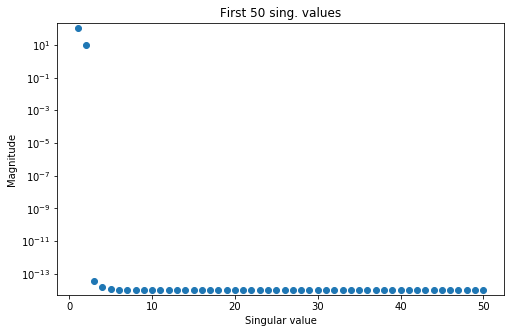

In [10]:
def plot_log_S(S, n):
    x_data = range(1, n + 1)
    
    plt.rcParams['figure.figsize'] = [8, 5]
    
    plt.scatter(x_data, S[:n])
    plt.yscale('log')
    plt.ylabel('Magnitude')
    plt.xlabel('Singular value')
    min, max = np.min(S[:n]), np.max(S[:n])
    plt.ylim(min / 2, 2 * max)  # setup y range correctly
    plt.title(f'First {n} sing. values')
    
    plt.show()

plot_log_S(S, 50)

In [11]:
a = V_T[0].reshape(w, 1)
b = V_T[1].reshape(1, w)

# test for example that first two V_T vectors are orthonormal, 
# result is not zero and exactly one because of floating point errors
b @ a, np.sqrt(np.sum(a*a)), np.sqrt(np.sum(b*b))

(array([[7.99599102e-18]]), 1.0000000000000004, 1.0)

In [12]:
np.dot(V_T[0], V_T[0])

1.0000000000000009

### Truncated SVD and projection to basic vectors

projection to 

In [13]:
nr = 2

Ur = U[:, :nr]  # reduce the U matrix
Sr = np.diag(S)[:nr, :nr]  # create a diagonal matrix sigma and reduce it
Vr_T = V_T[:nr, :]  # reduces the V_T matrix
Vr = Vr_T.T

print(Ur.shape, Sr.shape, Vr_T.shape)

(500, 2) (2, 2) (2, 300)


In [14]:
Vr.T @ Vr  # V^T x V = I

array([[ 1.00000000e+00, -1.80411242e-16],
       [-1.80411242e-16,  1.00000000e+00]])

In [15]:
Ur.T @ Ur  # U^T x U = I

array([[1.00000000e+00, 5.55111512e-17],
       [5.55111512e-17, 1.00000000e+00]])

In [16]:
proj_V = A @ Vr_T.T
# proj_V[:, 2]


In [17]:
A_p = proj_V @ Vr_T
# plot_A(A_p, times, wavelengths)  
np.allclose(A, A_p)  # reconstruciton of a reaction from projection matrix yields the A

True

### Projection to $\mathbf V$ basis

$$\mathbf A = \mathbf{U\Sigma V^T} = \mathbf{CS^T}$$

Truncated SVD

$$\boldsymbol{\mathrm{A_r}} \approx \boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}}\ \boldsymbol{\mathrm{V^T_r}}=\mathbf{CS^T}$$

Projection matrix

$$\mathbf{P_V} = \mathbf{AV}$$

$$\mathbf{A} = \mathbf{P_VV^{-1} = P_VV^T}$$

No handles with labels found to put in legend.


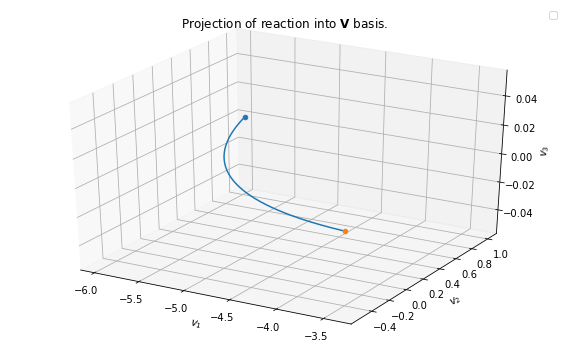

In [18]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

plt.rcParams['figure.figsize'] = [8, 5]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(proj_V[:, 0], proj_V[:, 1])#, proj_V[:, 2])
ax.scatter(proj_V[0, 0], proj_V[0, 1])#, proj_V[0, 2], label=f't={times[0]}')
ax.scatter(proj_V[-1, 0], proj_V[-1, 1])#, proj_V[-1, 2], label=f't={times[-1]}')

ax.set_xlabel("$v_1$")
ax.set_ylabel("$v_2$")
ax.set_zlabel("$v_3$")
ax.set_title("Projection of reaction into $\mathbf{V}$ basis.")

plt.legend()
plt.tight_layout()
plt.show()


### Rotation matrix R

\mathbf A = \mathbf{CS^T = CR^{-1}RS^T=C_{new}S_{new}^T}

$$\mathbf{V^{-1}V = V^TV = I = U^TU = U^{-1}U}$$

$$\mathbf{A = U\Sigma V^T = U\Sigma R^{-1}RV^T}$$

$$\mathbf{C = U\Sigma R^{-1} \qquad S^T = RV^T}$$

$$\mathbf R = \begin{bmatrix}
     1 & R_{12} & R_{13} \\
     R_{21} & 1 & R_{23} \\
     R_{31} & R_{32} & 1  
\end{bmatrix}$$


$$\mathbf{R = S^T V}$$

In [33]:
%matplotlib inline

R = ST @ Vr
R
ST.shape

(2, 300)

In [34]:
print(np.allclose(R @ Vr.T, ST))  # S^T == R V^T
print(np.allclose(Ur @ Sr @ np.linalg.inv(R), C))  # C == U x sigma R^-1

True
True


In [35]:
def ssq(R):
    
    ST_new = R @ Vr.T
    C_new = Ur @ Sr @ np.linalg.inv(R)
#     C_new = np.linalg.lstsq(ST_new.T, A.T)[0].T

    # apply non-*negativlity constaint
    ST_new *= ST_new > 0
    C_new *= C_new > 0
    
    A_new = C_new @ ST_new
    return A_new, C_new, ST_new, np.sum((A - A_new) ** 2)

In [36]:
# normalize R
R = ST @ Vr
R = np.diag(1 / np.abs(np.diag(R))) @ R
R

array([[-1.        ,  0.40703788],
       [-1.34785665, -1.        ]])

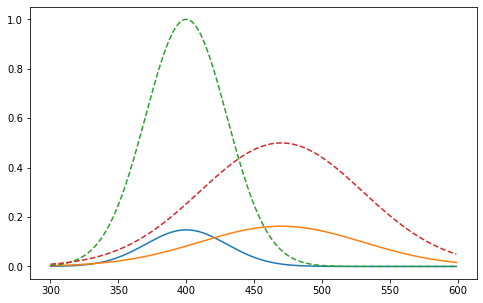

In [38]:
# plot spectra for different Rs
R = ST @ Vr
R = np.diag(1 / np.abs(np.diag(R))) @ R

R[0, 1] = 0.40703788
R[1, 0] =   -1.34785665

ST_new = R @ Vr.T
ST_new *= ST_new > 0
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(wavelengths, ST_new.T)
plt.plot(wavelengths, ST.T, '--')
plt.show()

4.744159104380159e-27


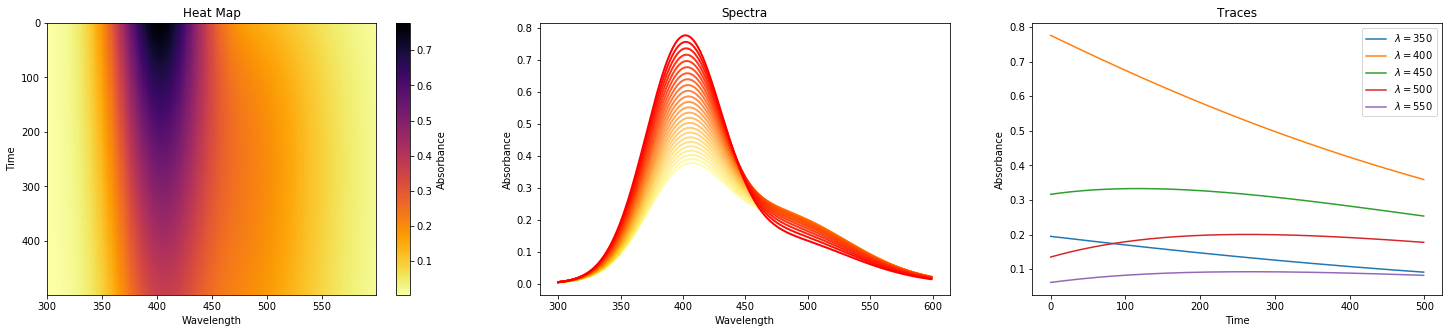

In [30]:
A_new, C_new, ST_new, s = ssq(R)
print(s)
plot_A(A_new, times, wavelengths)   

## Area of feasible solutions (AFS)

In [39]:
m = 100
par1 = np.linspace(0, 0.75, m)
par2 = np.linspace(-9, 0, m)

log_ssqs = np.zeros((m, m), dtype=np.float64)

for i in range(m):
    for j in range(m):
        
        R[0, 1] = par1[i]
        R[1, 0] = par2[j]
        
        if np.isclose(par1[i], 1/par2[j]):  # singularity
            log_ssqs[i, j] = np.nan
            continue
        
        A_new, C_new, ST_new, s = ssq(R)
        log_ssqs[i, j] = np.log10(s)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


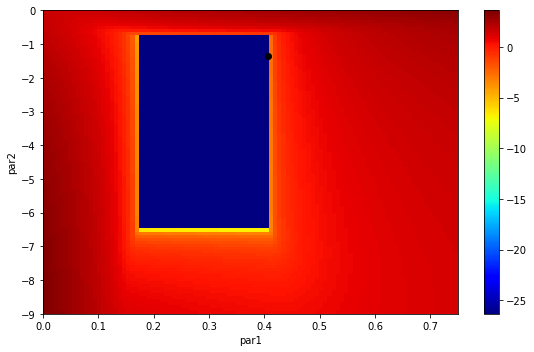

In [41]:
# %matplotlib qt
plt.rcParams['figure.figsize'] = [8, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

X, Y = np.meshgrid(par1, par2)
# log_ssqs[log_ssqs < -5] = -5

m = ax.pcolormesh(X, Y, log_ssqs.T, cmap='jet')

ax.scatter(0.40703788, -1.34785665, color='black')

ax.set_xlabel("par1")
ax.set_ylabel("par2")
plt.colorbar(mappable=m)
# ax.set_zlabel("log ssq")
# ax.set_title("Projection of reaction into $\mathbf{V}$ basis.")

# plt.legend()
plt.tight_layout()
plt.show()


In [42]:
AFS = np.argwhere(log_ssqs < -25)

par1s = par1[AFS[:, 0]]
par2s = par2[AFS[:, 1]]

Ss_new = np.zeros((par1s.shape[0], ST.shape[0], ST.shape[1]))
Cs_new = np.zeros((par1s.shape[0], C.shape[0], C.shape[1]))

for i in range(par1s.shape[0]):
    R[0, 1] = par1s[i]
    R[1, 0] = par2s[i]

    A_new, C_new, ST_new, s = ssq(R)
    Ss_new[i] = ST_new
    Cs_new[i] = C_new



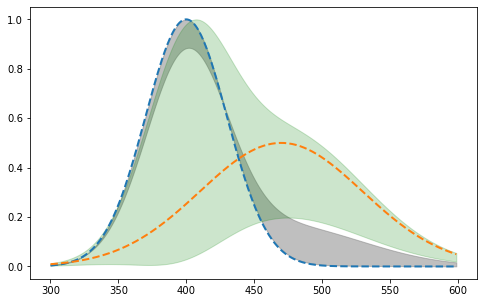

In [43]:
plt.rcParams['figure.figsize'] = [8, 5]

S1s = np.asarray([Ss_new[i, 0, :] for i in range(Ss_new.shape[0])])
S2s = np.asarray([Ss_new[i, 1, :] for i in range(Ss_new.shape[0])])

S1_ranges = np.vstack((S1s.min(axis=0, keepdims=False), S1s.max(axis=0, keepdims=False)))
S2_ranges = np.vstack((S2s.min(axis=0, keepdims=False), S2s.max(axis=0, keepdims=False)))


# plt.plot(wavelengths, S1s[::100].T, color='gray', lw=0.5)
# plt.plot(wavelengths, S2s[::100].T, color='green', lw=0.5)

plt.fill_between(wavelengths, S1_ranges[0] / S1_ranges[1].max(), S1_ranges[1]/ S1_ranges[1].max(), color='gray', alpha=0.5)
plt.fill_between(wavelengths, S2_ranges[0] / S2_ranges[1].max(), S2_ranges[1]/ S2_ranges[1].max(), color='green', alpha=0.2)


plt.plot(wavelengths, ST.T, '--', lw=2)
plt.show()

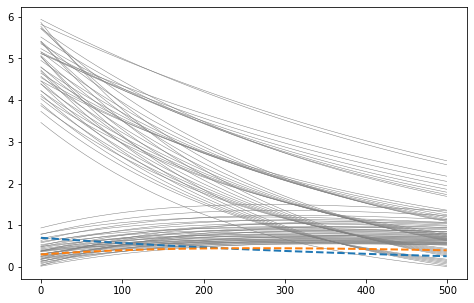

In [142]:
for _C in Cs_new[::50]:
    plt.plot(times, _C, color='gray', lw=0.5)
plt.plot(times, C, '--', lw=2)
plt.show()

## Global fit

Now, we are ready for the global fit, but first some theory.

$$\mathbf A = \mathbf{U\Sigma V^T} = \mathbf{CE}$$

$$\boldsymbol{\mathrm{Y_r}} = \boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}}\ \boldsymbol{\mathrm{V^T_r}}=\boldsymbol{\mathrm{C}}\ \boldsymbol{\mathrm{A}}$$

Spectra matrix $\boldsymbol{\mathrm{A}}$ must be linear combination of $\boldsymbol{\mathrm{V^T_r}}$ row vectors. Let's define a coefficient matrix $\boldsymbol{\mathrm{K}}$.

$$\boldsymbol{\mathrm{A}} = \boldsymbol{\mathrm{K}}\ \boldsymbol{\mathrm{V^T_r}}$$


In actual fitting, we don't need to compute with all of the data matrix $\boldsymbol{\mathrm{Y}}$, but we utilize the SVD that we performed.


$$\boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}}\ \boldsymbol{\mathrm{V^T_r}} = \boldsymbol{\mathrm{C}}\ \boldsymbol{\mathrm{K}}\ \boldsymbol{\mathrm{V^T_r}}$$

$$\boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}} = \boldsymbol{\mathrm{C}}\ \boldsymbol{\mathrm{K}}$$

To estimate $\boldsymbol{\mathrm{K}}$ from this matrix equation, we mutiply both sides of the equation from the left by $\boldsymbol{\mathrm{C^+}}$, which is Moore-Penrose pseudoinverse of concentration matrix. $\boldsymbol{\mathrm{C^+}} = \left(\boldsymbol{\mathrm{C^T}}\boldsymbol{\mathrm{C}}\right)^{-1}\boldsymbol{\mathrm{C^T}}$.

$$\boldsymbol{\mathrm{C^+}}\boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}} = \boldsymbol{\mathrm{C^+}}\boldsymbol{\mathrm{C}}\ \boldsymbol{\mathrm{K}}$$

$$\boldsymbol{\mathrm{C^+}}\boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}} = \boldsymbol{\mathrm{I}}\ \boldsymbol{\mathrm{K}}$$

$$\boldsymbol{\mathrm{C^+}}\boldsymbol{\mathrm{U_r}}\ \boldsymbol{\mathrm{S_r}} = \boldsymbol{\mathrm{K}}$$

This is just a classical operator equation Ax=B, system of linear equations. We solve it by least squares.


In [291]:
from scipy.linalg import lstsq
# lmfit is a great library, it is a wrapper around scipy.optimize.minimize and curve_fit with many other stuff
from lmfit import Parameters, report_fit, Minimizer

# initialize concentration, epsilon and coefficient matrices
C_guess = np.zeros((t, n))
E_guess = np.zeros((n, w))
K = np.zeros((n, nr))

# define parameters through lmfit class Parameters, we keep c0 fixed to 1
# specify initial values, bounds and if the we want parameters to be fixed (vary=False) or be fitted (vary=True)
params = Parameters()
params.add('c0', value=1, min=0, max=np.inf, vary=False)
params.add('k1', value=1, min=0, max=np.inf, vary=True)
params.add('k2', value=0.5, min=0, max=np.inf, vary=True)

for par in params.items():
    print(par[1].value)

# this is our A->B->C model, since the k1 can be equal to k2 during fitting, we have to define also model model for k1=k2, the equation for it is different,
# othervise, we would get zero division errors. This process can be avoided by numerical integration, which is convenient for more complicated models
def calc_C(c0, k1, k2, C):
    diff = 1e-8
    C[:, 0] = c0 * np.exp(-k1 * times)  # [A] = c0 * exp(-k1 * t)
    if np.abs(k1 - k2) < diff:  # k1 == k2
        C[:, 1] = c0 * k1 * times * np.exp(-k1 * times)  # [B] = c0 * k1 * t * exp(-k1 * t)
    else:
        C[:, 1] = c0 * (k1 / (k2 - k1)) * (np.exp(-k1 * times) - np.exp(-k2 * times))  # [B] = c0 * (k1 / (k2 - k1)) * (exp(-k1 * t) - exp(-k2 * t))
    C[:, 2] = c0 - C[:, 0] - C[:, 1]  # [C] = c0 - [A] - [B]

# calculate dot product of Ur and Sr beforehand
UrSr = Ur @ Sr
print(UrSr.shape)

# define residuals function that will be minimized
def residuals(params):
    global K, E_guess  # this command does not have anything to do with global analysis, we just make K and E_guess global variables (not local) :)
    c0, k1, k2 = params['c0'].value, params['k1'].value, params['k2'].value
    # calculate concetration matrix according to our model for parameters c0, k1 and k2
    calc_C(c0, k1, k2, C_guess)
    # calculates the coefficient matrix K, this is shortcut of computing C_guess+ @ Ur @ Sr, so no need to calculate pseudoinverse
    K = lstsq(C_guess, UrSr)[0]
    # calculate epsilon matrix according to just computed K
    E_guess = K @ Vr_T
    # construct data matrix from C_guess and E_guess
    A_guess = C_guess @ E_guess
    # calculate the residuals, here, we don't add any weights to the residual matrix (assuming the weights are 1)
    R = A - A_guess
    # return matrix of residuals
    return R

# define minimizer, needed for calculation of confidence intervals
m = Minimizer(residuals, params)

# minimize the residuals for two parameters k1 and k2, c0 is fixed
result = m.minimize(method='leastsq')  # leastsq - Lavenberg-Marquardt algorithm, other are possible as well

# report_fit function creates the report and prints it (function fit_report only return report as a string)
report_fit(result)

1
1
0.5
(500, 2)


IndexError: index 2 is out of bounds for axis 1 with size 2

## Fitted spectra

Now, we can see, that both parameters $k_1$ and $k_2$ are basically the same as original parameters that we used to construct the data. We can now plot the found spectra and compare them to gaussian spectra we used to construct the data. Result is really accurate, given the amount of noise, that we added to the data. Here we can appreciate the power of Singular value decomposition.

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
for i in range(n):
    plt.plot(wavelengths, E[i], label=f'Species {i+1}', lw=3)
for i in range(n):
    plt.plot(wavelengths, E_guess[i], label='Fit', color=(0, 0, 0, 0.7), lw=2)
plt.xlabel('Wavelength')
plt.ylabel('Epsilon $\epsilon$')
plt.legend()
plt.show()

## Confidence intervals and correlation between parameters

The error of parameters in fit report are given in the confidence level of $1\sigma$. That is 68.27% probability that the value lies in the interval $\left(\overline{x} - \sigma, \overline{x} + \sigma\right)$, where $\overline{x}$ is the average value. Errors are calculated from the covariance matrix. For modern and correct estimation of confindence intervals, we can use the functions in [lmfit package](https://lmfit.github.io/lmfit-py/confidence.html). Read for more information, but in sumary, in some models (eg. sum of exponentials), estimation of parameter errors from covariance matrix could be wrong. Lmfit package provides function to calculate confidence intervals for these parameters correctly. Also, 2D confidence plot for two parameters is possible. The calculation takes some time, because the parameters are varied and others reoptimized by fitting. This can be really computationaly demanding for complicated models.

The below code prints confidence intervals for $1\sigma$, $2\sigma$ and $3\sigma$. The confidence intervals are symetrical and errors at $1\sigma$ are comparable to that estimated directly from fitting, so the estimation from covarinace matrix is correct and this analysis wouldn't be necessary. The next cell shows 2D correlation of $k_1$ and $k_2$. We can see that it is a nice elipse, so it really behaves normally.

There is also possibility to estimate confidence intervals and correlations by Markov Chain Monte Carlo (MCMC), for that, see the above link to lmfit package.

In [123]:
from lmfit import report_ci, conf_interval

ci = conf_interval(m, result, sigmas=(1, 2, 3))
report_ci(ci)

       99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 k1:  -0.00006  -0.00004  -0.00002   0.01500  +0.00002  +0.00004  +0.00006
 k2:  -0.00004  -0.00002  -0.00001   0.00800  +0.00001  +0.00002  +0.00004


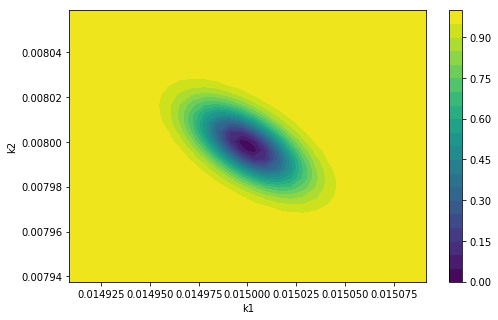

In [124]:
from lmfit import conf_interval2d

def confidence_interval2D(x_name: str, y_name: str, nx: float = 10, ny: float = 10):
    cx, cy, grid = conf_interval2d(m, result, x_name, y_name, nx, ny)
    plt.rcParams['figure.figsize'] = [8, 5]
    plt.contourf(cx, cy, grid, np.linspace(0, 1, 21))
    plt.xlabel(x_name)
    plt.colorbar()
    plt.ylabel(y_name)
    plt.show()

confidence_interval2D('k1', 'k2', 30, 30)

In [126]:
import timeit

%timeit m.minimize(method='leastsq')

22.5 ms ± 593 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Final remarks and discussion
